In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd "gdrive/My Drive/Colab Notebooks/VinBrain_Intern/W2/1.SIIM-UNet"

/content/gdrive/My Drive/Colab Notebooks/VinBrain_Intern/W2/1.SIIM-UNet


In [ ]:
# package to read dcm file
!pip install pydicom 

In [ ]:
import torch
import numpy as np 
import pandas as pd 
import pydicom, cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
import time
from torch.nn import functional as F
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor
import torchvision
import torch.nn as nn
import torch.optim as optim

In [ ]:
df = pd.read_csv('preprocessing_data.csv')

In [ ]:
# decode rle into mask of XRays Image
def run_length_decode(rle, height = 1024, width = 1024, fill_value = 1):
    if rle == "-1": 
      return np.zeros((height, width), np.float32) # negative case
    # init mask matrix
    component = np.zeros((height, width), np.float32)
    # flatten init matrix into list
    component = component.reshape(-1)
    # processing rle
    rle = rle[1: -1] # ignore character "[", "]"
    # get all value from rle, store in tempString
    tempString = []
    for eachRLE in rle.split(','):
      s = eachRLE.replace('\'', '')
      tempString.extend([int(s) for s in s.strip().split(" ")])
    # convert into numpy array  
    rle = np.asarray(tempString)
    # convert rle into mask
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start + index
        end = start + length
        component[start: end] = fill_value # value in rle is idx of pixel 1 in matrix we want
        start = end
    # reshape into mask matrix with shape (width, height)
    component = component.reshape(width, height).T
    return component

In [ ]:
# return mask, image from .dcm and rle
def getMaskAndImg(dataframe, idx):
    ds = pydicom.dcmread(dataframe["filepath"][idx])
    img = ds.pixel_array # img is 2-D matrix
    mask = run_length_decode(dataframe["EncodedPixels"][idx]) # convert rle into mask
    img = np.stack((img, ) * 3, axis=-1) # get matrix shape (width, height, 3)
    return img, mask

In [ ]:
# transform image, by albumentation
class ImageTransform():
    def __init__(self, size, mean, std):
      self.transform = {
          "train": A.Compose([
                        A.HorizontalFlip(p=0.5),
                        A.ShiftScaleRotate(
                          shift_limit = 0,
                          scale_limit = 0.1,
                          rotate_limit = 10,
                          p = 0.5,
                          border_mode = cv2.BORDER_CONSTANT   
                        ),
                        A.GaussNoise(),
                        A.Resize(size, size),
                        A.Normalize(mean=mean, std=std, p = 1),
                        ToTensor()
                    ]),
          "val": A.Compose([
                        A.Resize(size, size), 
                        A.Normalize(mean=mean, std=std, p = 1),
                        ToTensor()
                  ])
      }
    def __call__(self, image, mask, phase):
      return self.transform[phase](image = image, mask = mask)

In [ ]:
# SIIM ACR
class SIIMDataset(Dataset):
    def __init__(self, dataframe, fnames, size, mean, std, phase = "train"):
        self.dataframe = dataframe
        self.fnames = fnames
        self.phase = phase
        self.transforms = ImageTransform(size, mean, std)

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        indice_inDataFrame = self.dataframe.index[self.dataframe['UID'] == image_id].tolist()[0]
        image, mask = getMaskAndImg(self.dataframe, indice_inDataFrame) # img, mask are arrays
        augmentedData = self.transforms(image = image, mask = mask, phase = self.phase)
        image = augmentedData['image']
        mask = augmentedData['mask']
        return image, mask 
    def __len__(self):
        return len(self.fnames)

In [ ]:
# sampled dataset
def sampledDataset(df, fold):
    df_positiveCase = df[df["Pneumothorax"] == 1]
    df_negativeCase = df[df["Pneumothorax"] == 0]
    df_negativeCase_sampled = df_negativeCase.sample(len(df_positiveCase) + 1000, random_state = 2019)
    newSub_Dataframe = pd.concat([df_positiveCase, df_negativeCase_sampled])
    kfold = StratifiedKFold(n_splits = 5, random_state = 43, shuffle = True)
    df_split = newSub_Dataframe
    # k_fold validation
    train_idx, val_idx = list(kfold.split(X = df_split["UID"], y = df_split["Pneumothorax"]))[fold]
    train_df, val_df = df_split.iloc[train_idx], df_split.iloc[val_idx]
    f_names_datatrain = train_df.iloc[:, 0].values.tolist()
    f_names_dataval = val_df.iloc[:, 0].values.tolist()
    size = 512
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_dataset = SIIMDataset(train_df, f_names_datatrain, size, mean, std, phase = "train")
    val_dataset = SIIMDataset(val_df, f_names_dataval, size, mean, std, phase = "val")
    return {
          "train": DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 4),
          "val":  DataLoader(val_dataset, batch_size = 8, shuffle = True, num_workers = 4)
      }

In [ ]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

In [ ]:
def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

In [ ]:
def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [ ]:
def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

In [ ]:
def metric(probability, truth, threshold = 0.5, reduction = 'none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)
        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

In [ ]:
class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha * self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 245kB 51.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=f87b68e6d6e5dda1496e925b80db76469a153eb59ae16f7abc43e585be1d479e
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=b99dc35e5072fe7fd1bbb1f176db62e518548f5e57bd5b9dfe3075fde964f5a6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [ ]:
import segmentation_models_pytorch as smp
import torch

In [ ]:
model = smp.Unet('se_resnext50_32x4d', encoder_weights="imagenet", activation = None)
inp = torch.rand((2, 3, 512, 512)).cuda()
out = model(inp)
out.size()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


NameError: ignored

In [ ]:
dataloader = sampledDataset(df, 2)
train_dataloader = dataloader["train"]

[tensor([[[[-1.5014, -1.3644, -1.3987,  ..., -1.5357, -1.5870, -1.4329],
           [-1.5357, -1.5357, -1.5870,  ..., -1.4843, -1.5357, -1.5528],
           [-1.5528, -1.4672, -1.4672,  ..., -1.4158, -1.5357, -1.5357],
           ...,
           [-1.5185, -1.5870, -1.4843,  ..., -1.5699, -1.5870, -1.5357],
           [-1.5870, -1.5185, -1.5699,  ..., -1.5528, -1.6213, -1.5528],
           [-1.5528, -1.5014, -1.5185,  ..., -1.4500, -1.5185, -1.5014]],
 
          [[-1.3880, -1.4930, -1.3704,  ..., -1.3880, -1.5105, -1.4055],
           [-1.4405, -1.3704, -1.3529,  ..., -1.4230, -1.3704, -1.4755],
           [-1.3354, -1.4055, -1.3179,  ..., -1.4580, -1.3880, -1.3354],
           ...,
           [-1.4755, -1.4405, -1.4055,  ..., -1.5630, -1.3704, -1.4230],
           [-1.4055, -1.4230, -1.4405,  ..., -1.4930, -1.4580, -1.3529],
           [-1.4055, -1.4230, -1.3529,  ..., -1.4055, -1.4580, -1.3704]],
 
          [[-1.0898, -1.1421, -1.1421,  ..., -1.1944, -1.1944, -1.2293],
           [-

In [ ]:
model = smp.Unet('se_resnext50_32x4d', encoder_weights="imagenet", activation = None)
fold = 1
total_folds = 5
lr = 5e-4
num_epochs = 100
best_loss = float("inf")
device = torch.device("cuda:0")
torch.set_default_tensor_type("torch.cuda.FloatTensor")
criterion = MixedLoss(0.3, 3.5)
optimizer = optim.Adam( model.parameters(), lr = lr)
# model_path = './model.pth'
# state_dict = torch.load(model_path, map_location = 'cpu')
# model.load_state_dict(state_dict["state_dict"])
model.to(device = device)
accumulation_steps = 32 // 8
best_loss = float("inf")

In [ ]:
losses = {phase: [] for phase in ["train", "val"]}
iou_scores = {phase: [] for phase in ["train", "val"]}
dice_scores = {phase: [] for phase in ["train", "val"]}

In [ ]:
# checkpoint = torch.load("./model.pth")
# model.load_state_dict(checkpoint["state_dict"])
# optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
for epoch in range(num_epochs):
    meter = Meter("train", epoch)
    start = time.strftime("%H:%M:%S")
    model.train(True)
    running_loss = 0.0
    optimizer.zero_grad()
    dataloader = sampledDataset(df, 2)
    train_dataloader = dataloader["train"]
    val_dataloader = dataloader["val"]
    total_batches = len(train_dataloader)
    for itr, batch in enumerate(train_dataloader):
        images, targets = batch
        images = images.to(device)
        masks = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss = loss / accumulation_steps    
        loss.backward()
        if (itr + 1 ) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        running_loss += loss.item()
        outputs = outputs.detach().cpu()
        meter.update(targets, outputs)

    epoch_loss = (running_loss * accumulation_steps) / total_batches
    dice, iou = epoch_log("train", epoch, epoch_loss, meter, start)
    losses["train"].append(epoch_loss)
    dice_scores["train"].append(dice)
    iou_scores["train"].append(iou)
    torch.cuda.empty_cache()

    meter = Meter("val", epoch)
    start = time.strftime("%H:%M:%S")
    model.train(False)
    running_loss = 0.0
    total_batches = len(val_dataloader)
    optimizer.zero_grad()
    for itr, batch in enumerate(val_dataloader):
        images, targets = batch
        images = images.to(device)
        masks = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss = loss / accumulation_steps    
        running_loss += loss.item()
        outputs = outputs.detach().cpu()
        meter.update(targets, outputs)

    epoch_loss = (running_loss * accumulation_steps) / total_batches
    dice, iou = epoch_log("val", epoch, epoch_loss, meter, start)
    losses["val"].append(epoch_loss)
    dice_scores["val"].append(dice)
    iou_scores["val"].append(iou)
    torch.cuda.empty_cache()
    if epoch_loss < best_loss:
        print("-------OH YEAH---------")
        best_loss = epoch_loss
        state = {
                "epoch": epoch,
                "best_loss": best_loss,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
        }
        print("-----------------------")
        torch.save(state, "./model_v2.pth")
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 3.7742 | dice: 0.1521 | dice_neg: 0.0691 | dice_pos: 0.2591 | IoU: 0.1736
Loss: 2.4000 | dice: 0.4951 | dice_neg: 0.6155 | dice_pos: 0.3183 | IoU: 0.2222
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 2.2696 | dice: 0.2512 | dice_neg: 0.2129 | dice_pos: 0.3226 | IoU: 0.2283
Loss: 1.9627 | dice: 0.1953 | dice_neg: 0.0769 | dice_pos: 0.3591 | IoU: 0.2546
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.7727 | dice: 0.3596 | dice_neg: 0.3897 | dice_pos: 0.3468 | IoU: 0.2495
Loss: 1.7608 | dice: 0.3828 | dice_neg: 0.3725 | dice_pos: 0.3940 | IoU: 0.2941
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.6012 | dice: 0.4116 | dice_neg: 0.4773 | dice_pos: 0.3580 | IoU: 0.2580
Loss: 1.5314 | dice: 0.3571 | dice_neg: 0.3443 | dice_pos: 0.3843 | IoU: 0.2785
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.6210 | dice: 0.4349 | dice_neg: 0.5197 | dice_pos: 0.3602 | IoU: 0.2627
Loss: 1.4722 | dice: 0.4443 | dice_neg: 0.4818 | dice_pos: 0.3868 | IoU: 0.2823
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.5989 | dice: 0.4401 | dice_neg: 0.5218 | dice_pos: 0.3675 | IoU: 0.2711
Loss: 1.4434 | dice: 0.4906 | dice_neg: 0.5769 | dice_pos: 0.3909 | IoU: 0.2869
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.5480 | dice: 0.4571 | dice_neg: 0.5421 | dice_pos: 0.3789 | IoU: 0.2768
Loss: 1.2558 | dice: 0.5870 | dice_neg: 0.7162 | dice_pos: 0.3979 | IoU: 0.2985
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.4457 | dice: 0.5237 | dice_neg: 0.6396 | dice_pos: 0.3960 | IoU: 0.2991
Loss: 1.4485 | dice: 0.5717 | dice_neg: 0.6884 | dice_pos: 0.4003 | IoU: 0.2973



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.4721 | dice: 0.4712 | dice_neg: 0.5586 | dice_pos: 0.3943 | IoU: 0.2901
Loss: 1.4497 | dice: 0.5082 | dice_neg: 0.5893 | dice_pos: 0.3932 | IoU: 0.2941



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.4503 | dice: 0.4918 | dice_neg: 0.5918 | dice_pos: 0.3915 | IoU: 0.2894
Loss: 1.4987 | dice: 0.4030 | dice_neg: 0.3875 | dice_pos: 0.4141 | IoU: 0.3181



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.4093 | dice: 0.5202 | dice_neg: 0.6372 | dice_pos: 0.3980 | IoU: 0.2983
Loss: 1.3259 | dice: 0.6503 | dice_neg: 0.8370 | dice_pos: 0.3895 | IoU: 0.2969



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.3454 | dice: 0.5547 | dice_neg: 0.6891 | dice_pos: 0.4101 | IoU: 0.3075
Loss: 1.5977 | dice: 0.3250 | dice_neg: 0.2465 | dice_pos: 0.4162 | IoU: 0.3089



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.4280 | dice: 0.5180 | dice_neg: 0.6373 | dice_pos: 0.3919 | IoU: 0.2908
Loss: 1.3056 | dice: 0.6043 | dice_neg: 0.7616 | dice_pos: 0.3763 | IoU: 0.2806



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.4387 | dice: 0.5301 | dice_neg: 0.6516 | dice_pos: 0.4047 | IoU: 0.3035
Loss: 1.2639 | dice: 0.6588 | dice_neg: 0.8502 | dice_pos: 0.4021 | IoU: 0.3020



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2603 | dice: 0.5481 | dice_neg: 0.6646 | dice_pos: 0.4214 | IoU: 0.3140
Loss: 1.2620 | dice: 0.5332 | dice_neg: 0.5787 | dice_pos: 0.4536 | IoU: 0.3418



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.3053 | dice: 0.5891 | dice_neg: 0.7457 | dice_pos: 0.4074 | IoU: 0.3106
Loss: 1.2606 | dice: 0.6598 | dice_neg: 0.8210 | dice_pos: 0.4173 | IoU: 0.3254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2819 | dice: 0.5672 | dice_neg: 0.6977 | dice_pos: 0.4281 | IoU: 0.3258
Loss: 1.3162 | dice: 0.6139 | dice_neg: 0.7693 | dice_pos: 0.4188 | IoU: 0.3175



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.3382 | dice: 0.5110 | dice_neg: 0.6071 | dice_pos: 0.4166 | IoU: 0.3120
Loss: 1.2192 | dice: 0.6002 | dice_neg: 0.7440 | dice_pos: 0.3970 | IoU: 0.2990
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2257 | dice: 0.5894 | dice_neg: 0.7341 | dice_pos: 0.4220 | IoU: 0.3171
Loss: 1.4304 | dice: 0.6683 | dice_neg: 0.8745 | dice_pos: 0.3762 | IoU: 0.2856



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2596 | dice: 0.6170 | dice_neg: 0.7792 | dice_pos: 0.4250 | IoU: 0.3259
Loss: 1.4060 | dice: 0.6391 | dice_neg: 0.7998 | dice_pos: 0.3869 | IoU: 0.2932



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.3534 | dice: 0.5316 | dice_neg: 0.6452 | dice_pos: 0.4096 | IoU: 0.3068
Loss: 1.2764 | dice: 0.6329 | dice_neg: 0.8064 | dice_pos: 0.4116 | IoU: 0.3140



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2697 | dice: 0.5635 | dice_neg: 0.6932 | dice_pos: 0.4222 | IoU: 0.3175
Loss: 1.3160 | dice: 0.6831 | dice_neg: 0.8714 | dice_pos: 0.4060 | IoU: 0.3098



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1658 | dice: 0.6129 | dice_neg: 0.7637 | dice_pos: 0.4389 | IoU: 0.3338
Loss: 1.2856 | dice: 0.6078 | dice_neg: 0.7427 | dice_pos: 0.4086 | IoU: 0.3122



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1849 | dice: 0.5970 | dice_neg: 0.7309 | dice_pos: 0.4506 | IoU: 0.3421
Loss: 1.1976 | dice: 0.6284 | dice_neg: 0.7600 | dice_pos: 0.4549 | IoU: 0.3540
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2759 | dice: 0.6097 | dice_neg: 0.7489 | dice_pos: 0.4415 | IoU: 0.3389
Loss: 1.2149 | dice: 0.5980 | dice_neg: 0.7048 | dice_pos: 0.4574 | IoU: 0.3478



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1410 | dice: 0.6284 | dice_neg: 0.7768 | dice_pos: 0.4482 | IoU: 0.3384
Loss: 1.1606 | dice: 0.6659 | dice_neg: 0.8249 | dice_pos: 0.4513 | IoU: 0.3518
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1789 | dice: 0.6281 | dice_neg: 0.7761 | dice_pos: 0.4522 | IoU: 0.3450
Loss: 1.2763 | dice: 0.5429 | dice_neg: 0.6373 | dice_pos: 0.4125 | IoU: 0.3080



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2485 | dice: 0.5821 | dice_neg: 0.7071 | dice_pos: 0.4367 | IoU: 0.3311
Loss: 1.3021 | dice: 0.6500 | dice_neg: 0.8183 | dice_pos: 0.4227 | IoU: 0.3303



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1116 | dice: 0.6353 | dice_neg: 0.7921 | dice_pos: 0.4552 | IoU: 0.3497
Loss: 1.3705 | dice: 0.6839 | dice_neg: 0.8600 | dice_pos: 0.4210 | IoU: 0.3322



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0639 | dice: 0.6436 | dice_neg: 0.7962 | dice_pos: 0.4669 | IoU: 0.3573
Loss: 1.1901 | dice: 0.6598 | dice_neg: 0.8167 | dice_pos: 0.4448 | IoU: 0.3402



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1063 | dice: 0.6454 | dice_neg: 0.7931 | dice_pos: 0.4619 | IoU: 0.3539
Loss: 1.2635 | dice: 0.5610 | dice_neg: 0.6323 | dice_pos: 0.4435 | IoU: 0.3292



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1440 | dice: 0.6203 | dice_neg: 0.7604 | dice_pos: 0.4549 | IoU: 0.3474
Loss: 1.2105 | dice: 0.5967 | dice_neg: 0.6873 | dice_pos: 0.4732 | IoU: 0.3669



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1923 | dice: 0.6026 | dice_neg: 0.7288 | dice_pos: 0.4460 | IoU: 0.3406
Loss: 1.2995 | dice: 0.4585 | dice_neg: 0.4846 | dice_pos: 0.4203 | IoU: 0.3190



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2115 | dice: 0.6226 | dice_neg: 0.7627 | dice_pos: 0.4523 | IoU: 0.3486
Loss: 1.2276 | dice: 0.6012 | dice_neg: 0.6931 | dice_pos: 0.4489 | IoU: 0.3485



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2094 | dice: 0.6246 | dice_neg: 0.7661 | dice_pos: 0.4489 | IoU: 0.3436
Loss: 1.2674 | dice: 0.5761 | dice_neg: 0.6537 | dice_pos: 0.4549 | IoU: 0.3506



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2130 | dice: 0.6137 | dice_neg: 0.7496 | dice_pos: 0.4587 | IoU: 0.3520
Loss: 1.2572 | dice: 0.6134 | dice_neg: 0.7437 | dice_pos: 0.4216 | IoU: 0.3222



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1268 | dice: 0.6332 | dice_neg: 0.7865 | dice_pos: 0.4560 | IoU: 0.3500
Loss: 1.3576 | dice: 0.6951 | dice_neg: 0.9367 | dice_pos: 0.3642 | IoU: 0.2858



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2883 | dice: 0.6119 | dice_neg: 0.7574 | dice_pos: 0.4417 | IoU: 0.3410
Loss: 1.3042 | dice: 0.6343 | dice_neg: 0.7778 | dice_pos: 0.4282 | IoU: 0.3294



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1950 | dice: 0.6364 | dice_neg: 0.7882 | dice_pos: 0.4451 | IoU: 0.3401
Loss: 1.2585 | dice: 0.6237 | dice_neg: 0.7537 | dice_pos: 0.4480 | IoU: 0.3451



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.2842 | dice: 0.5477 | dice_neg: 0.6498 | dice_pos: 0.4332 | IoU: 0.3272
Loss: 1.1910 | dice: 0.6572 | dice_neg: 0.8409 | dice_pos: 0.4249 | IoU: 0.3235



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1279 | dice: 0.6199 | dice_neg: 0.7647 | dice_pos: 0.4496 | IoU: 0.3462
Loss: 1.1808 | dice: 0.6645 | dice_neg: 0.8248 | dice_pos: 0.4272 | IoU: 0.3318



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1769 | dice: 0.6251 | dice_neg: 0.7700 | dice_pos: 0.4554 | IoU: 0.3506
Loss: 1.2347 | dice: 0.6658 | dice_neg: 0.8526 | dice_pos: 0.4014 | IoU: 0.3063



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1096 | dice: 0.6307 | dice_neg: 0.7681 | dice_pos: 0.4682 | IoU: 0.3639
Loss: 1.2922 | dice: 0.6129 | dice_neg: 0.7699 | dice_pos: 0.3950 | IoU: 0.3025



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1088 | dice: 0.6143 | dice_neg: 0.7406 | dice_pos: 0.4705 | IoU: 0.3606
Loss: 1.2817 | dice: 0.6846 | dice_neg: 0.8870 | dice_pos: 0.4098 | IoU: 0.3174



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1148 | dice: 0.6539 | dice_neg: 0.8162 | dice_pos: 0.4551 | IoU: 0.3504
Loss: 1.2771 | dice: 0.6272 | dice_neg: 0.7466 | dice_pos: 0.4387 | IoU: 0.3394



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1150 | dice: 0.6633 | dice_neg: 0.8182 | dice_pos: 0.4700 | IoU: 0.3653
Loss: 1.1177 | dice: 0.6747 | dice_neg: 0.8473 | dice_pos: 0.4554 | IoU: 0.3536
-------OH YEAH---------
-----------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0248 | dice: 0.6667 | dice_neg: 0.8192 | dice_pos: 0.4787 | IoU: 0.3672
Loss: 1.2030 | dice: 0.6934 | dice_neg: 0.8749 | dice_pos: 0.4391 | IoU: 0.3453



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1125 | dice: 0.6482 | dice_neg: 0.7955 | dice_pos: 0.4650 | IoU: 0.3578
Loss: 1.4464 | dice: 0.5066 | dice_neg: 0.5366 | dice_pos: 0.4554 | IoU: 0.3504



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0750 | dice: 0.6299 | dice_neg: 0.7692 | dice_pos: 0.4649 | IoU: 0.3547
Loss: 1.2953 | dice: 0.6390 | dice_neg: 0.7639 | dice_pos: 0.4506 | IoU: 0.3518



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0727 | dice: 0.6556 | dice_neg: 0.8056 | dice_pos: 0.4819 | IoU: 0.3721
Loss: 1.2247 | dice: 0.6115 | dice_neg: 0.7558 | dice_pos: 0.4245 | IoU: 0.3169



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9644 | dice: 0.6810 | dice_neg: 0.8390 | dice_pos: 0.4850 | IoU: 0.3758
Loss: 1.2247 | dice: 0.6882 | dice_neg: 0.8739 | dice_pos: 0.4269 | IoU: 0.3348



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0499 | dice: 0.6563 | dice_neg: 0.7994 | dice_pos: 0.4811 | IoU: 0.3699
Loss: 1.4839 | dice: 0.6831 | dice_neg: 0.8805 | dice_pos: 0.3992 | IoU: 0.3117



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0811 | dice: 0.6435 | dice_neg: 0.7785 | dice_pos: 0.4773 | IoU: 0.3693
Loss: 1.4608 | dice: 0.6286 | dice_neg: 0.7773 | dice_pos: 0.4082 | IoU: 0.3190



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0407 | dice: 0.6585 | dice_neg: 0.8053 | dice_pos: 0.4776 | IoU: 0.3671
Loss: 1.2042 | dice: 0.6745 | dice_neg: 0.8354 | dice_pos: 0.4532 | IoU: 0.3546



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0537 | dice: 0.6613 | dice_neg: 0.8102 | dice_pos: 0.4820 | IoU: 0.3734
Loss: 1.4121 | dice: 0.6675 | dice_neg: 0.8615 | dice_pos: 0.3855 | IoU: 0.3014



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9908 | dice: 0.6850 | dice_neg: 0.8516 | dice_pos: 0.4806 | IoU: 0.3713
Loss: 1.2375 | dice: 0.6894 | dice_neg: 0.8740 | dice_pos: 0.4359 | IoU: 0.3471



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0259 | dice: 0.6945 | dice_neg: 0.8583 | dice_pos: 0.4821 | IoU: 0.3776
Loss: 1.2461 | dice: 0.6758 | dice_neg: 0.8504 | dice_pos: 0.4329 | IoU: 0.3393



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1009 | dice: 0.6719 | dice_neg: 0.8204 | dice_pos: 0.4741 | IoU: 0.3736
Loss: 1.1524 | dice: 0.6784 | dice_neg: 0.8477 | dice_pos: 0.4442 | IoU: 0.3497



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9444 | dice: 0.6904 | dice_neg: 0.8479 | dice_pos: 0.4954 | IoU: 0.3843
Loss: 1.2217 | dice: 0.6866 | dice_neg: 0.8750 | dice_pos: 0.4121 | IoU: 0.3186



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9802 | dice: 0.6793 | dice_neg: 0.8303 | dice_pos: 0.4839 | IoU: 0.3770
Loss: 1.3440 | dice: 0.6947 | dice_neg: 0.9097 | dice_pos: 0.3996 | IoU: 0.3141



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0222 | dice: 0.6834 | dice_neg: 0.8518 | dice_pos: 0.4742 | IoU: 0.3691
Loss: 1.4373 | dice: 0.6897 | dice_neg: 0.9071 | dice_pos: 0.3749 | IoU: 0.2967



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9817 | dice: 0.6816 | dice_neg: 0.8312 | dice_pos: 0.4946 | IoU: 0.3845
Loss: 1.1906 | dice: 0.6996 | dice_neg: 0.9039 | dice_pos: 0.4221 | IoU: 0.3329



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0560 | dice: 0.6795 | dice_neg: 0.8438 | dice_pos: 0.4787 | IoU: 0.3759
Loss: 1.2936 | dice: 0.6862 | dice_neg: 0.8980 | dice_pos: 0.3858 | IoU: 0.3004



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9565 | dice: 0.7039 | dice_neg: 0.8652 | dice_pos: 0.4934 | IoU: 0.3851
Loss: 1.2638 | dice: 0.6642 | dice_neg: 0.8177 | dice_pos: 0.4390 | IoU: 0.3387



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0838 | dice: 0.6959 | dice_neg: 0.8584 | dice_pos: 0.4820 | IoU: 0.3800
Loss: 1.2939 | dice: 0.6977 | dice_neg: 0.8850 | dice_pos: 0.4145 | IoU: 0.3289



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9734 | dice: 0.6925 | dice_neg: 0.8504 | dice_pos: 0.4918 | IoU: 0.3835
Loss: 1.2147 | dice: 0.6881 | dice_neg: 0.8944 | dice_pos: 0.4109 | IoU: 0.3252



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1253 | dice: 0.6653 | dice_neg: 0.8161 | dice_pos: 0.4732 | IoU: 0.3724
Loss: 1.2526 | dice: 0.5607 | dice_neg: 0.6602 | dice_pos: 0.4191 | IoU: 0.3249



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.1193 | dice: 0.6610 | dice_neg: 0.8144 | dice_pos: 0.4675 | IoU: 0.3655
Loss: 1.3648 | dice: 0.6717 | dice_neg: 0.8561 | dice_pos: 0.4096 | IoU: 0.3208



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0692 | dice: 0.6830 | dice_neg: 0.8400 | dice_pos: 0.4864 | IoU: 0.3799
Loss: 1.4619 | dice: 0.6883 | dice_neg: 0.9346 | dice_pos: 0.3419 | IoU: 0.2664



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0360 | dice: 0.7098 | dice_neg: 0.8772 | dice_pos: 0.4895 | IoU: 0.3811
Loss: 1.1950 | dice: 0.6736 | dice_neg: 0.8550 | dice_pos: 0.4189 | IoU: 0.3204



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9521 | dice: 0.6915 | dice_neg: 0.8414 | dice_pos: 0.5091 | IoU: 0.3934
Loss: 1.2636 | dice: 0.6750 | dice_neg: 0.8844 | dice_pos: 0.3990 | IoU: 0.3104



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9957 | dice: 0.6761 | dice_neg: 0.8203 | dice_pos: 0.4936 | IoU: 0.3803
Loss: 1.1715 | dice: 0.6717 | dice_neg: 0.8281 | dice_pos: 0.4410 | IoU: 0.3427



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0159 | dice: 0.6937 | dice_neg: 0.8539 | dice_pos: 0.4848 | IoU: 0.3765
Loss: 1.2345 | dice: 0.6620 | dice_neg: 0.8091 | dice_pos: 0.4623 | IoU: 0.3607



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0262 | dice: 0.6866 | dice_neg: 0.8373 | dice_pos: 0.4906 | IoU: 0.3835
Loss: 1.3445 | dice: 0.5937 | dice_neg: 0.7242 | dice_pos: 0.4143 | IoU: 0.3128



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9413 | dice: 0.7042 | dice_neg: 0.8652 | dice_pos: 0.5045 | IoU: 0.3951
Loss: 1.1271 | dice: 0.6959 | dice_neg: 0.8839 | dice_pos: 0.4340 | IoU: 0.3386



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.8753 | dice: 0.7228 | dice_neg: 0.8799 | dice_pos: 0.5194 | IoU: 0.4105
Loss: 1.2571 | dice: 0.6635 | dice_neg: 0.8359 | dice_pos: 0.4306 | IoU: 0.3378



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9584 | dice: 0.7007 | dice_neg: 0.8628 | dice_pos: 0.5002 | IoU: 0.3940
Loss: 1.4775 | dice: 0.6368 | dice_neg: 0.7832 | dice_pos: 0.4097 | IoU: 0.3231



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9232 | dice: 0.6965 | dice_neg: 0.8424 | dice_pos: 0.5129 | IoU: 0.4025
Loss: 1.1942 | dice: 0.6729 | dice_neg: 0.8346 | dice_pos: 0.4620 | IoU: 0.3628



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9148 | dice: 0.7085 | dice_neg: 0.8592 | dice_pos: 0.5158 | IoU: 0.4064
Loss: 1.2452 | dice: 0.6500 | dice_neg: 0.8124 | dice_pos: 0.4214 | IoU: 0.3238



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.8871 | dice: 0.7136 | dice_neg: 0.8772 | dice_pos: 0.5084 | IoU: 0.3986
Loss: 1.4046 | dice: 0.6680 | dice_neg: 0.8232 | dice_pos: 0.4357 | IoU: 0.3526



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9579 | dice: 0.6991 | dice_neg: 0.8616 | dice_pos: 0.4847 | IoU: 0.3787
Loss: 1.2021 | dice: 0.6335 | dice_neg: 0.7940 | dice_pos: 0.4171 | IoU: 0.3133



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0620 | dice: 0.6614 | dice_neg: 0.8131 | dice_pos: 0.4738 | IoU: 0.3673
Loss: 1.3226 | dice: 0.6899 | dice_neg: 0.8917 | dice_pos: 0.4073 | IoU: 0.3180



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9037 | dice: 0.6861 | dice_neg: 0.8360 | dice_pos: 0.4988 | IoU: 0.3894
Loss: 1.3129 | dice: 0.6843 | dice_neg: 0.8797 | dice_pos: 0.4051 | IoU: 0.3215



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9996 | dice: 0.6645 | dice_neg: 0.8076 | dice_pos: 0.4929 | IoU: 0.3861
Loss: 1.3422 | dice: 0.6567 | dice_neg: 0.8210 | dice_pos: 0.4146 | IoU: 0.3214



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9332 | dice: 0.7118 | dice_neg: 0.8781 | dice_pos: 0.4981 | IoU: 0.3885
Loss: 1.3039 | dice: 0.6819 | dice_neg: 0.8678 | dice_pos: 0.4154 | IoU: 0.3216



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0004 | dice: 0.7188 | dice_neg: 0.8888 | dice_pos: 0.4949 | IoU: 0.3933
Loss: 1.4231 | dice: 0.6859 | dice_neg: 0.9153 | dice_pos: 0.3718 | IoU: 0.2928



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0396 | dice: 0.7101 | dice_neg: 0.8692 | dice_pos: 0.4949 | IoU: 0.3900
Loss: 1.3176 | dice: 0.6858 | dice_neg: 0.8746 | dice_pos: 0.4093 | IoU: 0.3202



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0241 | dice: 0.7060 | dice_neg: 0.8644 | dice_pos: 0.4904 | IoU: 0.3887
Loss: 1.2634 | dice: 0.6736 | dice_neg: 0.8403 | dice_pos: 0.4526 | IoU: 0.3547



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0461 | dice: 0.6392 | dice_neg: 0.7575 | dice_pos: 0.4903 | IoU: 0.3798
Loss: 1.3908 | dice: 0.5671 | dice_neg: 0.6460 | dice_pos: 0.4391 | IoU: 0.3437



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 1.0077 | dice: 0.6733 | dice_neg: 0.8222 | dice_pos: 0.4908 | IoU: 0.3845
Loss: 1.3115 | dice: 0.6618 | dice_neg: 0.8466 | dice_pos: 0.3997 | IoU: 0.3165



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9130 | dice: 0.7028 | dice_neg: 0.8569 | dice_pos: 0.5118 | IoU: 0.4000
Loss: 1.2468 | dice: 0.6275 | dice_neg: 0.7583 | dice_pos: 0.4233 | IoU: 0.3285



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9958 | dice: 0.7032 | dice_neg: 0.8605 | dice_pos: 0.4986 | IoU: 0.3922
Loss: 1.3064 | dice: 0.6493 | dice_neg: 0.8053 | dice_pos: 0.4156 | IoU: 0.3171



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9628 | dice: 0.6925 | dice_neg: 0.8471 | dice_pos: 0.5056 | IoU: 0.3952
Loss: 1.4061 | dice: 0.6719 | dice_neg: 0.8815 | dice_pos: 0.3824 | IoU: 0.2976



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9158 | dice: 0.7345 | dice_neg: 0.9038 | dice_pos: 0.5090 | IoU: 0.4017
Loss: 1.1821 | dice: 0.6834 | dice_neg: 0.8508 | dice_pos: 0.4339 | IoU: 0.3401



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.8211 | dice: 0.7331 | dice_neg: 0.8964 | dice_pos: 0.5261 | IoU: 0.4129
Loss: 1.2957 | dice: 0.6678 | dice_neg: 0.8223 | dice_pos: 0.4439 | IoU: 0.3446



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.7952 | dice: 0.7427 | dice_neg: 0.9070 | dice_pos: 0.5371 | IoU: 0.4218
Loss: 1.3164 | dice: 0.6924 | dice_neg: 0.8841 | dice_pos: 0.4147 | IoU: 0.3235



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9625 | dice: 0.7152 | dice_neg: 0.8748 | dice_pos: 0.5128 | IoU: 0.4066
Loss: 1.5303 | dice: 0.6862 | dice_neg: 0.9324 | dice_pos: 0.3308 | IoU: 0.2641



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.9064 | dice: 0.7123 | dice_neg: 0.8733 | dice_pos: 0.5109 | IoU: 0.4020
Loss: 1.4152 | dice: 0.7004 | dice_neg: 0.9021 | dice_pos: 0.4121 | IoU: 0.3214



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.8236 | dice: 0.7439 | dice_neg: 0.9064 | dice_pos: 0.5332 | IoU: 0.4196
Loss: 1.2658 | dice: 0.6873 | dice_neg: 0.8905 | dice_pos: 0.4000 | IoU: 0.3126



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


Loss: 0.8307 | dice: 0.7291 | dice_neg: 0.8886 | dice_pos: 0.5276 | IoU: 0.4169
Loss: 1.1833 | dice: 0.6799 | dice_neg: 0.8533 | dice_pos: 0.4292 | IoU: 0.3384



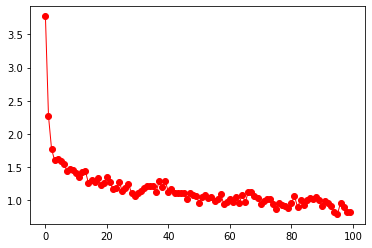

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(100).tolist(), losses["train"], 'ro-', label='line 1', linewidth=1)

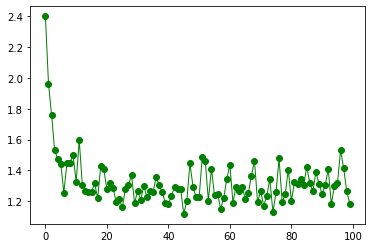

In [ ]:
plt.plot(np.arange(100).tolist(), losses["val"], 'go-', label='line 1', linewidth=1)

In [ ]:
import torch
import os
import numpy as np 
import pandas as pd 
import pydicom, cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor
import torchvision
import torch.nn as nn
import torch.optim as optim

In [ ]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = A.Compose(
            [
                A.Normalize(mean = mean, std = std, p = 1),
                A.Resize(size, size),
                ToTensor()
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".dcm")
        ds = pydicom.dcmread(path)
        image = ds.pixel_array
        image = np.stack((image, ) * 3, axis=-1)
        images = self.transform(image = image)["image"]
        return images

    def __len__(self):
        return self.num_samples

In [ ]:
def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [ ]:
model = UNetWithResnet50Encoder()
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 16
best_threshold = 0.5
min_size = 3500
device = torch.device("cpu")
df = pd.read_csv("./stage_2_sample_submission.csv")
model.to(device)
testset = DataLoader(
    TestDataset("stage_2_images", df, size, mean, std),
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
)
model.eval()
state = torch.load('./model_v3.pth', map_location = lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []

for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission_v1.csv', columns=['ImageId', 'EncodedPixels'], index=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/201 [00:00<?, ?it/s]